# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 18: Generalized Linear Models III. Multinomial Logistic Regression. Regularization of MNR. 

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix


from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

import collections

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

# Decision Trees

Decision trees are powerful and widely used models in machine learning and data science. They provide a systematic and intuitive approach to solving classification and regression problems. Decision trees mimic human decision-making processes by breaking down complex problems into a sequence of simpler decisions or conditions.

At its core, a decision tree is a flowchart-like structure that consists of nodes and branches. Each node represents a feature or attribute, and the branches represent the possible values or outcomes of that feature. The tree structure starts with a root node and branches out into intermediate nodes, known as internal nodes, and leaf nodes, which represent the final decision or prediction.

Example of decision tree would be:

![](_images/decision_tree_example.png)


The important thing is that there is a goal in mind e.g. to buy a car. Then, based on options and decisions, the path to the goal is defined with it.

In general, decision trees are used in decision analysis to help define best strategy to reach given goal.

In machine learning, and particularly in supervised learning, we use decision trees based on the data where goal was already reached. In that sense, what we are trying to do is to reverse-engineer the whole process, and based on data provided come up with the tree-like structure of rules, that can support the evidence in data.

Let's take a quick look at how we create decision trees with `sklearn` library. 

For this session we are going to use *Titanic* dataset, one of the few data sets that are widely known because it contains data of all Titanic survivors. For each of the passengers there is a set of characteristics and a flag variable *Survived* that marks if the passenger survived or not. As you can imagine, this is going to be classification problem at hand, and we will start by showing how decision trees can be used in classification.

In [2]:
df_train = pd.read_csv(os.path.join(data_dir, 'Titanic_train.csv'))

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's for the sake of quick overview run next cell without going into details:

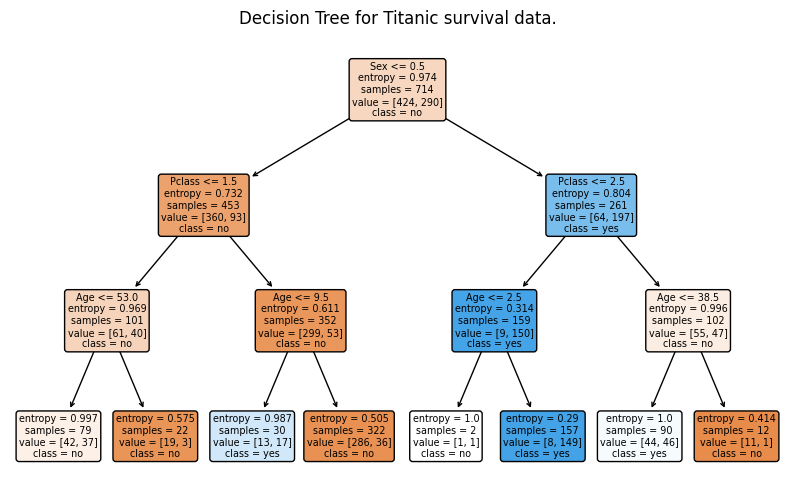

In [4]:
# select few predictors
df_train = df_train[['Survived', 'Pclass', 'Sex', 'Age']]

# encode binary categorical variable
df_train['Sex'] = df_train['Sex'].replace({'male': 0, 'female': 1})

# drop observations with NaN values
df_train = df_train.dropna()

# create DT
dc = DecisionTreeClassifier(max_depth=3, criterion='entropy')
# fit the DT
X, y = df_train.drop(columns=['Survived']), df_train[['Survived']]
dc.fit(X, y)

# plot the DT
fig = plt.figure(figsize=(10, 6))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)
plt.gca().set_title('Decision Tree for Titanic survival data.');

As you can see, there is 15 nodes in this tree. First node at the top is called tree root. Nodes at the bottom are called leafs. Each node contains 5 rows of information, and most of these are not that important at the moment. First row in each node shows the name of the predictor that algorithm used for creating the logical expression. Based on the truth of this expression does algorithm spawn another tree branch and node. 

But how does algorithm decide which predictor and value to use for each node's logical expression?

Here we have to make a short detour into **Information Theory** and describe important concepts that will make everything clear. And remember, we are still at classification problems. Later on we will move to a regression ones.

## Information theory

Information theory is a discipline that focuses on the mathematical study of information, its transmission, storage, and processing. Developed by Claude Shannon in the mid-20th century, information theory provides a quantitative framework to measure the amount of information contained in a message or data. It offers insights into how efficiently information can be encoded, transmitted, and decoded, while accounting for factors such as noise and uncertainty.

At the core of information theory is the concept of entropy, which quantifies the uncertainty or randomness in a set of data. Shannon's entropy measures the average amount of information needed to identify an outcome in a dataset. By analyzing the distribution and probabilities of outcomes, entropy enables us to understand the optimal encoding and compression schemes for efficient data representation. 

Information theory has found applications in various fields, including telecommunications, data compression, cryptography, and machine learning, providing a solid mathematical foundation for understanding and manipulating information in a quantitative manner.

The important concept that we are introducing here, for the purpose of creating decision trees is **entropy**. As already stated, it **quantifies the uncertainty or randomness in a set of data**.

Let us, in parallel, define **information content**, and let us view it from the perspective of a certain event happening. As you can already remember, we talked about term event when we spoke about probability. And this is exactly how we are going to approach describing these concepts.


### Information and Probability

For the sake of clear explanation, let's imagine each day at noon, you look through your windows, at the sky. Is it day or night? Day most probably. As a matter of fact, it is certainly day (except there is an eclipse). And since this surely must be a day, and not night, how informative is this insight to you? You could just as easily guessed that it is a day, and you would be right. Probability of being a day at noon is 99.99% (or something very close). 

This is very intuitive, right? If something is almost certain, than we are probably used to it, and that information is of low value to us. We can say it has a low information content. And randomness of this event is very low, right? 

If we sum this up, we can say that **event with high probability has low information content** (*self-information*).

In the scenario where there was an eclipse, it would be 'night', right? And this would be something you would eagerly rush to tell your friends. Why? Because it is of great value i.e. high information content. And we all know that eclipse has very low probability. Let's imagine we do not have ways of knowing the exact day it will happen, because we do, at this day and age. But this is not the point. The point is, **event with low probability has high information content**.

### Information content

Apparently, there are few other assumptions that Claude Shannon introduced, while defining information content as a concept. And while you may think that information content should be defined as $\frac{1}{P(E)}$, where $E$ is an event, it is defined as:

$$ I(E) = \log_{2}{\frac{1}{P(E)}}.$$

Using highschool knowledge of logarighms, we can write this in another form:

$$I(E) = - \log_{2}\bigl({P(E)}\bigr).$$

But why **logarithm**? Well, one of the assumptions was that if there are two events, $A$ and $B$, and $P(A) > P(B)$, then $I(A) < I(B)$. This of course can be satisfied with using $\frac{1}{P(E)}$ as an expression of information content. 

However, another assumption is that if there are two independent events $A$ and $B$, information content of them both happening should be the sum of information contents of each of them happening, or $I(P(A, B)) = I(P(A)) + I(P(B))$. If we remember from the probability theory, for two indepentend events $A$ and $B$, we had that:

$$P(A\cap B) = P(A, B) = P(A)P(B).$$

Because of this, logarithm was a convenient function to use to express information content.

Now, let's define Python function that will return information content for event based on it's probability.


In [5]:
def self_information(p: float = .5):
    return -np.log2(p)

In [6]:
# Self-information of event with .5 probability
self_information(.5)

1.0

You could say, that if we flip a fair coin, the information content of result being Heads is 1.0. This is also the maximal randomness, right? We can't say what result is more probable, since both are equaly probable. And since randomness is at it's peak, we say that the entropy is also maximal.

What about we plot information content as a function of probability?

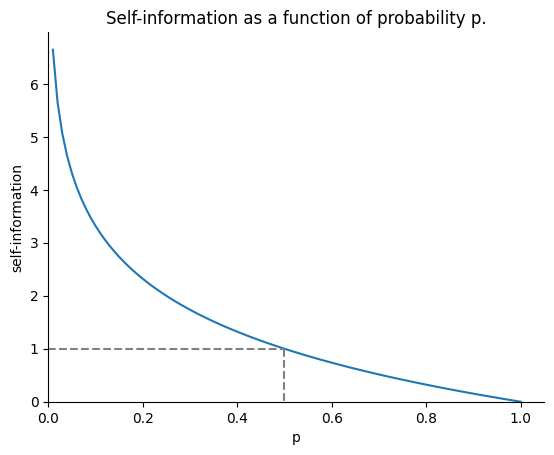

In [7]:
x = np.linspace(0.01, 1, 100)
y = self_information(x)
plt.plot(x, y)
sns.despine()
plt.xlabel('p')
plt.ylim(0)
plt.xlim(0)
plt.plot((.5, .5), (1, 0), '--', color='grey')
plt.plot((.0, .5), (1, 1), '--', color='grey')
plt.ylabel('self-information')
plt.title('Self-information as a function of probability p.');

Information of 5 independent throws (of fair coin), i.e. gettin sequence of results: **0 1 1 0 1**?

In [8]:
PH = .5
PT = .5

self_information(PT) + self_information(PH) + self_information(PH) + self_information(PT) + self_information(PT)

5.0

And what is an average information content for these throws

In [9]:
(3 * self_information(PH) + 2 * self_information(PT)) / 5

1.0

### Information Entropy

Now, what if we wanted to generalize above presented approach and define a way of defining average information content for random variable at hand? 

Let's start with the descrete random variable.

If we have **p** as a vector of probabilities for each possible state of a random variable X, then average information content, also called **information entropy**, would be defined as:

$$H(X)=-\sum_i p_ilog_2p_i$$

Defining it for continous random variable is very similar:

$$H(X)=\int p(x)log_2p(x)dx$$

How about we define Python function that will return information entropy of a descrete random variable which vector of probabilities is defined as **p**.

In [10]:
def entropy(p):
    return np.sum(p * self_information(p))

What is the information entropy of a random variable describing fair coin flip?

In [11]:
entropy([1/2, 1/2])

1.0

And what about fair six-sided dice?

In [12]:
entropy([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

2.584962500721156

And now, what about we plot entropy as a function of a probability of getting Heads in coin flip?

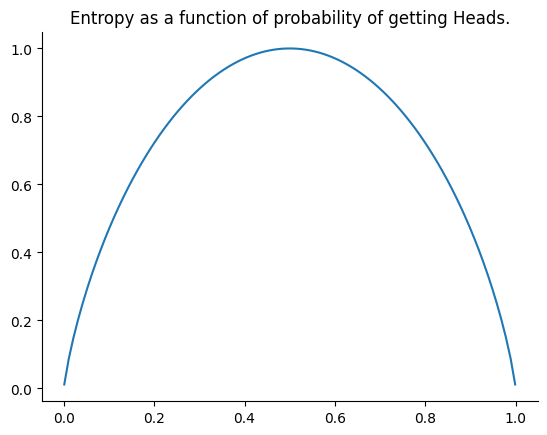

In [13]:
x = np.linspace(0.001, 0.999, 100)
y = list(map(entropy, list(zip(x, 1-x))))
plt.plot(x, y)
sns.despine()
plt.title('Entropy as a function of probability of getting Heads.');


Wait wait, what happened there? Where? Here `list(map(entropy, list(zip(x, 1-x))))`?

Let's go step by step.

In [14]:
x[:10], (1-x)[:10]

(array([0.001     , 0.01108081, 0.02116162, 0.03124242, 0.04132323,
        0.05140404, 0.06148485, 0.07156566, 0.08164646, 0.09172727]),
 array([0.999     , 0.98891919, 0.97883838, 0.96875758, 0.95867677,
        0.94859596, 0.93851515, 0.92843434, 0.91835354, 0.90827273]))

In [15]:
list(zip(x, 1-x))[:10]

[(0.001, 0.999),
 (0.01108080808080808, 0.988919191919192),
 (0.021161616161616163, 0.9788383838383838),
 (0.031242424242424245, 0.9687575757575757),
 (0.041323232323232324, 0.9586767676767677),
 (0.0514040404040404, 0.9485959595959595),
 (0.06148484848484849, 0.9385151515151515),
 (0.07156565656565657, 0.9284343434343434),
 (0.08164646464646465, 0.9183535353535354),
 (0.09172727272727273, 0.9082727272727272)]

In [16]:
list(map(entropy, list(zip(x, 1-x))[:10]))

[0.011407757737461138,
 0.08787596435469067,
 0.14791393481427534,
 0.20058479115485361,
 0.24832660995876613,
 0.292331543644311,
 0.3333112291872919,
 0.3717393976676705,
 0.4079542063302699,
 0.44220910087961685]

Now, let's try solving next problem. We have 12 balls, *blue* and *red*, and we have them ordered.

What is the information entropy of this group of balls in respect to the colors present?

We will define `DataFrame` to visualize this example:

In [17]:
df_balls = pd.DataFrame(['b', 'r', 'r', 'r', 'b', 'b', 'b', 'r', 'b', 'b', 'r', 'b']).reset_index().rename(columns={'index': 'num', 0: 'color'})

df_balls['num'] = df_balls['num'] + 1

df_balls['color_label'] = (df_balls['color'] == 'b').astype('int')

df_balls

,num,color,color_label
0,1,b,1
1,2,r,0
2,3,r,0
3,4,r,0
4,5,b,1
5,6,b,1
6,7,b,1
7,8,r,0
8,9,b,1
9,10,b,1


Let's define helper method that will take sequence representing each observation's belonging to a certain class, i.e. `df_balls['color_label']`.

In [18]:
def prepare_for_entropy(x):
    _, counts = np.unique(x, return_counts=True)
    return counts/np.sum(counts)

How does result of calling this method look like?

In [19]:
prepare_for_entropy(df_balls['color_label'])

array([0.41666667, 0.58333333])

These are the probabilities for each class.

Previously defined method `entropy` knows how to work with this.

In [20]:
entropy(prepare_for_entropy(df_balls['color_label']))

0.9798687566511528

This is all good, but how about we try to divide this set in two separate ones. Let's split it by order number so that all balls with order number bigger than 4 goes into one set, while the rest goes to another.

In [21]:
df_balls_1 = df_balls[df_balls['num'] > 5]
df_balls_2 = df_balls[df_balls['num'] <= 5]

What is the information entropy for each of these?

In [22]:
entropy(prepare_for_entropy(df_balls_1['color_label']))

0.863120568566631

In [23]:
entropy(prepare_for_entropy(df_balls_2['color_label']))

0.9709505944546686

### Information Gain

Now, what we saw previously is that after splitting our balls in two parts, entropies of each changed. We could easily end up in a scenario where each group's entropies are equal, regardless of the number of balls in each. Or, even with same entropies as the entropy of original group we split. 

We want to account for this, by scaling each group entropy by proportion of the balls ended up in it. And then, let's combine these entropies by summing them. Let's see what happens then.

This is how we will do it:

In [24]:
scaled_entropy_1 = entropy(prepare_for_entropy(df_balls_1['color_label'])) * df_balls_1.shape[0]/df_balls.shape[0]
scaled_entropy_2 = entropy(prepare_for_entropy(df_balls_2['color_label'])) * df_balls_2.shape[0]/df_balls.shape[0]

In [25]:
scaled_entropy_1, scaled_entropy_2

(0.5034869983305348, 0.4045627476894453)

In [26]:
scaled_entropy_1 + scaled_entropy_2

0.9080497460199801

And what was the entropy of original group?

In [27]:
entropy(prepare_for_entropy(df_balls['color_label']))

0.9798687566511528

Hmmm, so after splitting original set of balls, we managed to decrease combined entropy of groups?

So if by splitting data set we decrease the entropy, then we are practically gaining some information in the process, right? Therefore, this is can be called **information gain**, right? And that is exactly how the process is called and here is the definition.

The definition would go like this. Let's say we have a dataset of $N$ observations. And it's entropy is already known as $S_0$. Then, if we use variable $X$ for splitting (in our example this was the column with ordering number for each ball), and we have $x$ number of groups after splittin, then information gain $IG(X)$ is defined as:

$$ IG(X) = S_o - \sum_{i=1}^{x}{\frac{N_i}{N}}S_i$$

$N_i$ is number of observations in i-th group, while $S_i$ is the entropy of i-th group.

Let's define helper method for getting the information gain, based on:
* dataset,
* variable,
* variable threshold we use for splitting.

In [28]:
df_balls

,num,color,color_label
0,1,b,1
1,2,r,0
2,3,r,0
3,4,r,0
4,5,b,1
5,6,b,1
6,7,b,1
7,8,r,0
8,9,b,1
9,10,b,1


In [29]:
# let's define one simple holder for our results
ig_result = collections.namedtuple('gain', ['gain', 'group_a_entropy', 'group_b_entropy', 'group_a_entropy_scaled', 'group_b_entropy_scaled'])

def gain(df, column, threshold, label, criterion=entropy):
    # if threshold is for numerical column, then comparison is performed this way
    if isinstance(threshold, float) or isinstance(threshold, int):
        group_a, group_b = df[df[column] <= threshold], df[df[column] > threshold]
    # otherwise threshold for categorical variable is supported
    elif isinstance(threshold, str):
        group_a, group_b = df[df[column] == threshold], df[df[column] != threshold]
    # throw exception if threshold is of different type
    else:
        raise Exception(f'Unrecognized type of threshold: {type(threshold)}')
    
    # original set's entropy
    original_entropy = criterion(prepare_for_entropy(df[label]))

    # entropies of each group
    group_a_entropy = criterion(prepare_for_entropy(group_a[label]))
    group_b_entropy = criterion(prepare_for_entropy(group_b[label]))

    # we have to scale them because of their size
    group_a_entropy_scaled = group_a_entropy * len(group_a)/len(df)
    group_b_entropy_scaled = group_b_entropy * len(group_b)/len(df)

    # this information gain after split
    ig = original_entropy - (group_a_entropy_scaled + group_b_entropy_scaled)

    return ig_result(ig, 
                     group_a_entropy, 
                     group_b_entropy,
                     group_a_entropy_scaled,
                     group_b_entropy_scaled)

In [30]:
gain(df_balls, 'num', 5, 'color_label')

gain(gain=0.07181901063117269, group_a_entropy=0.9709505944546686, group_b_entropy=0.863120568566631, group_a_entropy_scaled=0.4045627476894453, group_b_entropy_scaled=0.5034869983305348)

Nice! And what about we change threshold value to 6?

In [31]:
gain(df_balls, 'num', 6, 'color_label')

gain(gain=0.020720839623908027, group_a_entropy=1.0, group_b_entropy=0.9182958340544896, group_a_entropy_scaled=0.5, group_b_entropy_scaled=0.4591479170272448)

Okay, so now we see that changing threshold value changes information gain. Can we try to find best threshold value that will have produce biggest information gain after splitting?

In [32]:
for i in range(1, len(df_balls)):
    ig, _, _ ,_, _ = gain(df_balls, 'num', i, 'color_label')

    print(f'If we split num at {i:>2} then IG={ig:.3f}')

If we split num at  1 then IG=0.069
If we split num at  2 then IG=0.004
If we split num at  3 then IG=0.062
If we split num at  4 then IG=0.169
If we split num at  5 then IG=0.072
If we split num at  6 then IG=0.021
If we split num at  7 then IG=0.001
If we split num at  8 then IG=0.043
If we split num at  9 then IG=0.007
If we split num at 10 then IG=0.004
If we split num at 11 then IG=0.069


How each of datasets looks like after this particular split?

In [33]:
df_balls[df_balls['num'] <= 4]

,num,color,color_label
0,1,b,1
1,2,r,0
2,3,r,0
3,4,r,0


In [34]:
df_balls[df_balls['num'] > 4]

,num,color,color_label
4,5,b,1
5,6,b,1
6,7,b,1
7,8,r,0
8,9,b,1
9,10,b,1
10,11,r,0
11,12,b,1


Wow. And let's use `sklearn's DecisionTreeClassifier` and see what are the results we have after using it on our dataset.

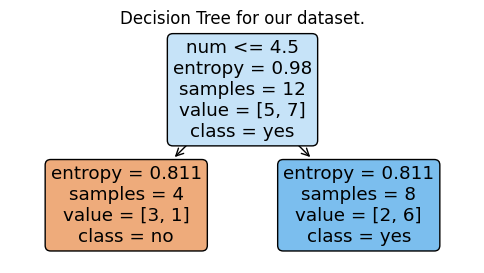

In [35]:
dc = DecisionTreeClassifier(max_depth=1, criterion='entropy')

dc.fit(df_balls[['num']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)
plt.gca().set_title('Decision Tree for our dataset.');

In [36]:
gain(df_balls, 'num', 4, 'color_label')

gain(gain=0.16859063219201997, group_a_entropy=0.8112781244591328, group_b_entropy=0.8112781244591328, group_a_entropy_scaled=0.2704260414863776, group_b_entropy_scaled=0.5408520829727552)

And what about categorical variables? What happens then?

Let's define augmented `df_balls` with one categorical variable, and check what happens then?

In [37]:
_balls = ['b', 'r', 'r', 'r', 'b', 'b', 'b', 'r', 'b', 'b', 'r', 'b']
_owner = ['jake', 'jake', 'jake', 'fin', 'fin', 'jake', 'fin', 'lsp', 'jake', 'lsp', 'lsp', 'lsp']
_num = list(range(12))

df_balls = pd.DataFrame(list(zip(_num, _owner, _balls)), columns=['num', 'owner', 'color'])#.rename(columns={'index': 'num', 0: 'color'})

df_balls['color_label'] = (df_balls['color'] == 'b').astype('int')

df_balls

,num,owner,color,color_label
0,0,jake,b,1
1,1,jake,r,0
2,2,jake,r,0
3,3,fin,r,0
4,4,fin,b,1
5,5,jake,b,1
6,6,fin,b,1
7,7,lsp,r,0
8,8,jake,b,1
9,9,lsp,b,1


Alright, let's do the the same steps, but for categorical variable `owner` now.

In [38]:
le = LabelEncoder()

le.fit(df_balls['owner'])

LabelEncoder()

In [39]:
le.classes_

array(['fin', 'jake', 'lsp'], dtype=object)

In [40]:
df_balls['owner_le'] = le.transform(df_balls['owner'])

In [41]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


In [42]:
for i in df_balls['owner_le'].unique():
    ig, _, _ ,_, _ = gain(df_balls, 'owner_le', int(i), 'color_label')
    print(f'If we split num at {i:>2} then IG={ig:.3f}')

If we split num at  1 then IG=0.010
If we split num at  0 then IG=0.007
If we split num at  2 then IG=0.000


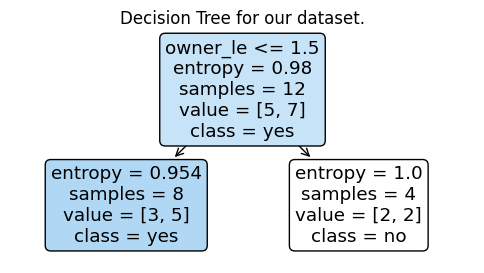

In [43]:
dc = DecisionTreeClassifier(max_depth=1, criterion='entropy', )

dc.fit(df_balls[['owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

In [44]:
df_balls['owner_le'].values

array([1, 1, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2])

In [45]:
le.inverse_transform(df_balls['owner_le'])

array(['jake', 'jake', 'jake', 'fin', 'fin', 'jake', 'fin', 'lsp', 'jake',
       'lsp', 'lsp', 'lsp'], dtype=object)

In [46]:
gain(df_balls, 'owner', 'lsp', 'color_label')

gain(gain=0.010246088034509437, group_a_entropy=1.0, group_b_entropy=0.954434002924965, group_a_entropy_scaled=0.3333333333333333, group_b_entropy_scaled=0.63628933528331)

Apparently, `DecisionTreeClassifier` doesn't work with categorical variables out of the box. Therefore, we need to encode them somehow. One way is to do it manually, like we did with `color` label. Other way is to use `LabelEncoder` or `OrdinalEncoder`.

Anyway, before we wrap up with entropy and information gain based on it, let's see what happens when there are multiple columns of different types. What happens then?

Well, algorithm goes and repeats the process of searching for best split, looking at each predictor and it's values.

Something like this.

In [47]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


We are going to use `num` and `owner_le` columns as predictors.

In [48]:
_results = []

for column in ['num', 'owner_le']:
    for i in df_balls[column].unique():
        ig, _, _ ,_, _ = gain(df_balls, column, int(i), 'color_label')
        print(f'If we split dataset on {column} at {i:>2} then IG={ig:.3f}')
        _results.append({'ig': ig, 'column': column, 'threshold': int(i)})

If we split dataset on num at  0 then IG=0.069
If we split dataset on num at  1 then IG=0.004
If we split dataset on num at  2 then IG=0.062
If we split dataset on num at  3 then IG=0.169
If we split dataset on num at  4 then IG=0.072
If we split dataset on num at  5 then IG=0.021
If we split dataset on num at  6 then IG=0.001
If we split dataset on num at  7 then IG=0.043
If we split dataset on num at  8 then IG=0.007
If we split dataset on num at  9 then IG=0.004
If we split dataset on num at 10 then IG=0.069
If we split dataset on num at 11 then IG=0.000
If we split dataset on owner_le at  1 then IG=0.010
If we split dataset on owner_le at  0 then IG=0.007
If we split dataset on owner_le at  2 then IG=0.000


In [49]:
pd.DataFrame(_results).sort_values(by='ig', ascending=False).iloc[0]

ig           0.168591
column            num
threshold           3
Name: 3, dtype: object

And how does `DecisionTreeClassifier` works in this case?

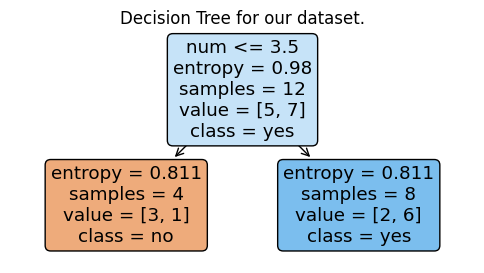

In [50]:
dc = DecisionTreeClassifier(max_depth=1, criterion='entropy', )

dc.fit(df_balls[['num', 'owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

This checks. We have figured the way decision tree is constructed! 

But, wait! Is this the end?

No.

This is just the first step. After this, we go and perform the same process on each of new nodes, and keep doing this until we end up with nodes with entropy 0. That is, when each of the leafs in our tree contains only observations of the same class.

How is this done?

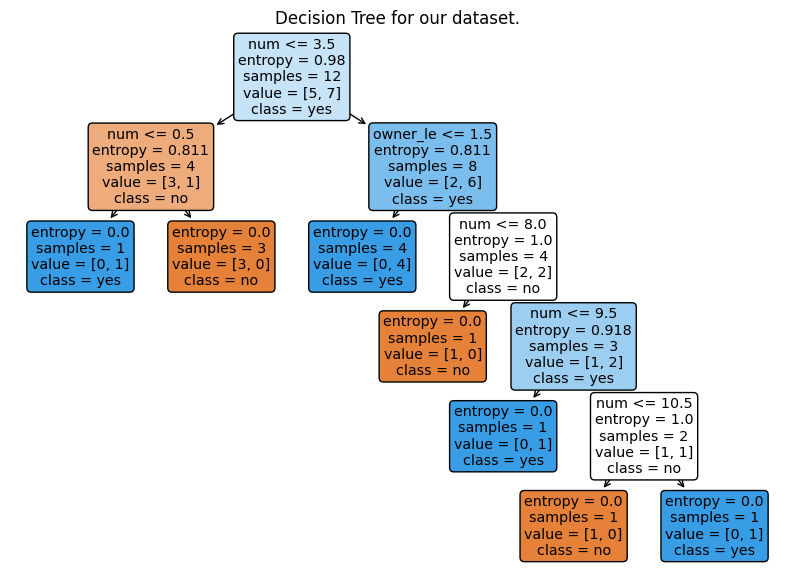

In [51]:
dc = DecisionTreeClassifier(criterion='entropy', )

dc.fit(df_balls[['num', 'owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(10, 7))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

From this example we can see that leafs have entropy of 0, either with one or more observations of the same class, in this case color.

### Gini impurity

So far we went into information theory to pick up exceptionally important concepts of self-information and entropy, and defined information entropy and information gain as a way to decide how to partition our dataset.

However, entropy is not the only approach in defining how informative our splits can be. Here, we will shortly define another way, namely **Gini impurity**.

This approach approaches the problem from the different angle. Here, we want to measure probability of classifying observation incorrectly.

Let's make this very clear with simple with an example. Again, we are going to resort to our good ole' friend coin. We are almost out of coins. Joking.

If we have a fair coin, and flip it, but in the mean time try to predict the outcome, what is a probability of predicting it correctly?

Well, there are 4 possible results:
- Outcome: H, Prediction: H, probability .5 * .5 = .25
- Outcome: T, Prediction: H, probability .5 * .5 = .25
- Outcome: H, Prediction: T, probability .5 * .5 = .25
- Outcome: T, Prediction: T, probability .5 * .5 = .25


Well, apparently the probability of predicting the outcome correctly is 50%.

We can define Gini impurity $G$ as:

$$ G(X) = \sum_{i=1}^{x}{p_i * (1 - p_i)},$$

where $X$ is a discrete random variable, and $x$ is the number of different possible states that random variable can have.

After fiddling a bit with this expression you get the next one:

$$ G(X) = 1 - \sum_{i=1}^{x}{p_{i}^2}.$$

More precisely, Gini impurity measures how often a randomly chosen element would be classified incorrectly if it was labeled randomly and indepenendly with distribution of labels in mind. 

In case of a coin flip, distribution is Bernoulli with $p=.5$. Anyway, Gini can be used for a discrete random variable with more than 2 outcomes just as easily.

Let's define Gini impurity helper function.


In [52]:
def gini(p):
    return 1 - np.sum(np.array(p)**2)

In [53]:
gini([.5, .5])

0.5

How about we do the same thing for Gini impurity, as we did with entropy. Let's plot Gini impurity as a function of probability p, for the case of coin.

Also, let's compare entropy with Gini impurity at the same time.

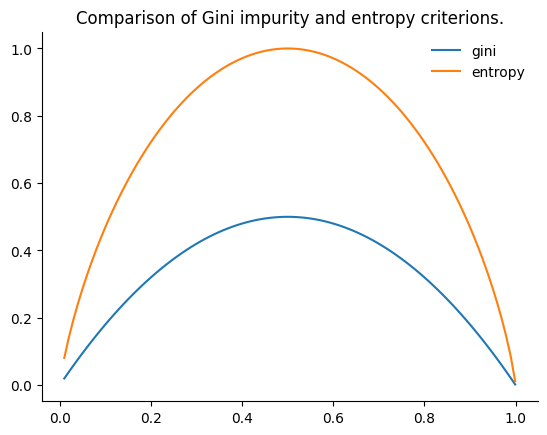

In [54]:
x = np.linspace(0.01, 0.999, 100)

y_gini = list(map(gini, list(zip(x, 1-x))))
y_entropy = list(map(entropy, list(zip(x, 1-x))))

plt.plot(x, y_gini, label='gini')
plt.plot(x, y_entropy, label='entropy')
sns.despine()
plt.legend(frameon=False)
plt.title('Comparison of Gini impurity and entropy criterions.');

You can see that Gini impurity and entropy are very similar, with entropy being 2 times the value of Gini impurity.

### Gini impurity

Just as we did introduce information gain based on entropy, we can introduce **Gini gain** based on Gini impurity.

If we have a dataset that is being split into two subsets based on some value of random variable $X$, then Gini gain is defined as:

$$ GG(X) = G_0 - \sum_{i=1}^{x}{\frac{N_i}{N}*G_i}.$$

Here $G_0$ is the Gini impurity of the original dataset, while $G_i$ is Gini impurity of each subset. $N_i$ is the cardinality of each of subsets. This is all the same as we did for information gain.


Let's do the same experiments as we did with information gain.

In [55]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


In [56]:
gain(df_balls, 'num', 5, 'color_label', criterion=gini)

gain(gain=0.01388888888888884, group_a_entropy=0.5, group_b_entropy=0.4444444444444444, group_a_entropy_scaled=0.25, group_b_entropy_scaled=0.2222222222222222)

Alright, and what about we search for the best value for the split, using both columns as we did before?

In [57]:
_results = []

for column in ['num', 'owner_le']:
    for i in df_balls[column].unique():
        ig, _, _ ,_, _ = gain(df_balls, column, int(i), 'color_label', criterion=gini)
        print(f'If we split dataset on {column} at {i:>2} then IG={ig:.3f}')
        _results.append({'ig': ig, 'column': column, 'threshold': int(i)})

If we split dataset on num at  0 then IG=0.032
If we split dataset on num at  1 then IG=0.003
If we split dataset on num at  2 then IG=0.042
If we split dataset on num at  3 then IG=0.111
If we split dataset on num at  4 then IG=0.048
If we split dataset on num at  5 then IG=0.014
If we split dataset on num at  6 then IG=0.000
If we split dataset on num at  7 then IG=0.028
If we split dataset on num at  8 then IG=0.005
If we split dataset on num at  9 then IG=0.003
If we split dataset on num at 10 then IG=0.032
If we split dataset on num at 11 then IG=0.000
If we split dataset on owner_le at  1 then IG=0.007
If we split dataset on owner_le at  0 then IG=0.005
If we split dataset on owner_le at  2 then IG=0.000


And how about we let `DecisionTreeClassifier` do the splitting?

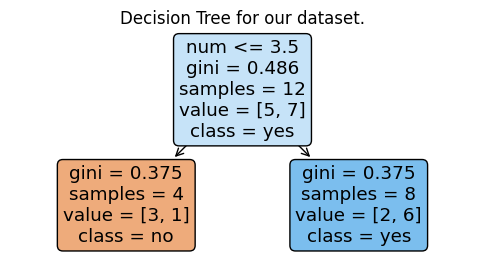

In [58]:
dc = DecisionTreeClassifier(max_depth=1, criterion='gini', )

dc.fit(df_balls[['num', 'owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

In [59]:
gain(df_balls, 'num', 3, 'color_label', criterion=gini)

gain(gain=0.11111111111111105, group_a_entropy=0.375, group_b_entropy=0.375, group_a_entropy_scaled=0.125, group_b_entropy_scaled=0.25)

This checks out too! Great. We introduced important concepts and implemented simple splitting while optimizing for both information and Gini gains.

### Regression and reduction of variance






### Overfitting, and pre-pruning and post-pruning





Up until now we have introduced 

### Further Reading

***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>